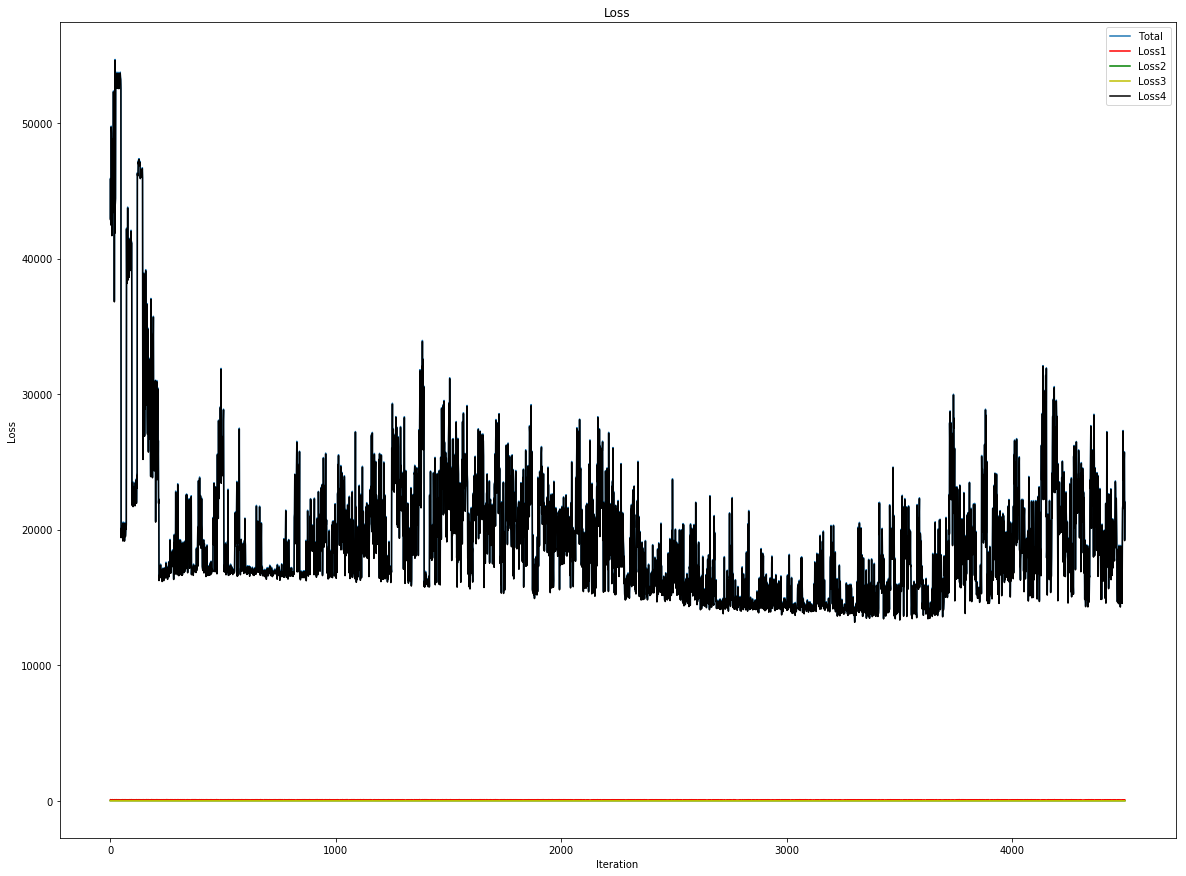

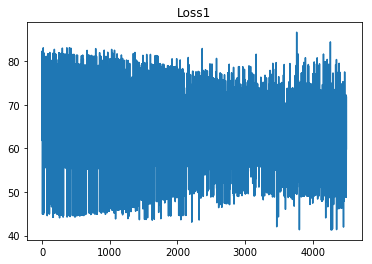

In [2]:
import os
import pickle
from pprint import pprint
import datetime
import numpy as np
from matplotlib import pyplot as plt
import torch
from structure_utils import *

dirname = 'Validation'

losses = []
with open(dirname+'/loss.txt', 'r') as f:
    for iteration in f:
        losses.append([float(term) for term in iteration.split()])
losses = np.array(losses)
# print(losses)
N_iters = losses.shape[0]

# Plot total loss
plt.figure(figsize=(20, 15))
plt.plot(range(N_iters), np.sum(losses, axis=1), label='Total')
plt.title('Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
# plt.show()

# Plot respective losses
colors = ['r', 'g', 'y', 'k']
for i in range(4):
    plt.plot(range(N_iters), losses[:, i], colors[i], label='Loss' + str(i+1))

plt.legend(loc='upper right')
plt.show()

# Plot loss1 separately
plt.figure()
plt.title('Loss1')
plt.plot(range(N_iters), losses[:, 0])
plt.show()


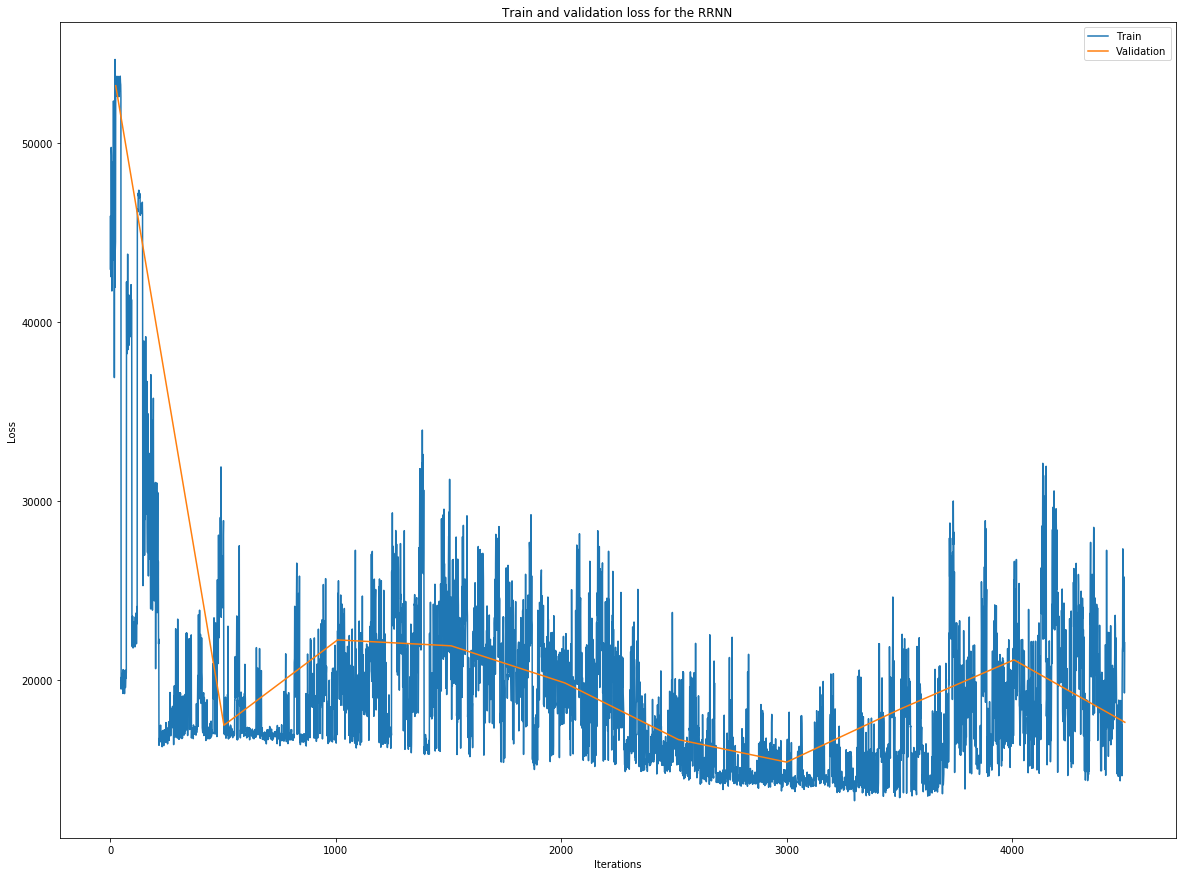

In [7]:
# Plot train and validation loss in the same figure

# Get validation losses
val = []
with open(dirname + '/val_loss.txt', 'r') as f:
    for iteration in f:
        val.append([float(term) for term in iteration.split()])
val = np.array(val)

# Plot
plt.figure(figsize=(20, 15))
plt.plot(range(N_iters), np.sum(losses, axis=1), label='Train')
valx = val[:, 0]  # The first column of val is the iteration numbers
plt.plot(valx, np.sum(val[:, 1:], axis=1), label='Validation')
plt.legend(loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Train and validation loss for the RRNN')
plt.show()

# Next do this for an actual GRU model.


In [ ]:
# Training and validation accuracy

val = []
with 

In [4]:
# Display hyperparameters and run information

params = pickle.load(open(dirname+'/hyperparameters.pkl', 'rb'))
pprint(params)

runtime = pickle.load(open(dirname+'/runtime.pkl', 'rb'))
print('\nRuntime: ' + str(datetime.timedelta(seconds=runtime)))

{'batch_size': 1,
 'debug': False,
 'epochs': 1,
 'epochs_per_checkpoint': 1,
 'lambdas': (20, 1, 0, 2),
 'learning_rate': 1e-05,
 'loss2_margin': 1,
 'multiplier': 0.001,
 'n_processes': 24,
 'nb_train': 4500,
 'nb_val': 500,
 'optimizer': 'adam',
 'samples': 10,
 'scoring_hidden_size': 128,
 'validate_every': 500,
 'verbose': True}

Runtime: 5:14:06.963332


In [5]:
# Display weight magnitudes

epochs = params['epochs']
magnitudes = np.zeros(epochs)
scoring = np.zeros(epochs)
for i in range(epochs):
    weights = torch.load(dirname + '/epoch_' + str(i + 1) + '.pt')
    for weight in weights:
        magnitudes[i] += weights[weight].norm()
        if 'scoring' in weight:
            scoring[i] += weights[weight].norm()

plt.figure()
plt.plot(range(epochs), magnitudes, 'g')
plt.title('Norm of weights')
plt.xlabel('Epoch')
plt.show()

plt.figure()
plt.plot(range(epochs), scoring, 'r')
plt.title('Norm of scoring')
plt.xlabel('Epoch')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'Validation/epoch_1.pt'

In [6]:
# Show 5 different structures from training

with open(dirname+'/structure.txt') as f:
    lines = f.readlines()
    structures = []
    for line in lines:
        if line != '\n':
            structures.append(line)
            
    spacing = 1000
    for i in range(0, N_iters, spacing):
        print('Iteration', i)
        print(structures[i])
        print()
    
    print('Final structure')
    print(structures[-1])

Iteration 0
[['x', 'h', 1, 'add', 'minus', 'G0'], ['h', 'G0', 1, 'add', 'minus', 'G1'], ['h', 'G1', 1, 'add', 'minus', 'G2'], ['h', 'G2', 1, 'add', 'minus', 'G3'], ['h', 'G3', 1, 'add', 'minus', 'G4'], ['h', 'G4', 1, 'add', 'minus', 'G5'], ['h', 'G5', 1, 'add', 'minus', 'G6'], ['h', 'G6', 1, 'add', 'minus', 'G7'], ['h', 'G7', 1, 'add', 'minus', 'G8']]


Iteration 1000
[['x', '0', 2, 'add', 'minus', 'G0'], ['x', '0', 2, 'add', 'minus', 'G1'], ['x', '0', 2, 'add', 'minus', 'G2'], ['x', '0', 2, 'add', 'minus', 'G3'], ['x', '0', 2, 'add', 'minus', 'G4'], ['G0', 'G1', 0, 'mul', 'minus', 'G5'], ['G5', 'G2', 0, 'mul', 'minus', 'G6'], ['G6', 'G3', 0, 'mul', 'minus', 'G7'], ['G7', 'G4', 0, 'mul', 'minus', 'G8']]


Iteration 2000
[['x', '0', 0, 'add', 'minus', 'G0'], ['x', '0', 0, 'add', 'minus', 'G1'], ['x', '0', 0, 'add', 'minus', 'G2'], ['x', '0', 0, 'add', 'minus', 'G3'], ['x', '0', 0, 'add', 'minus', 'G4'], ['G0', 'G1', 1, 'mul', 'minus', 'G5'], ['G5', 'G2', 1, 'mul', 'minus', 'G6'], ['G6',

In [7]:
# Show GRU structures
import ast

best = None
fewest_differences = np.Inf
best_iter = 0
for i, structure in enumerate(structures):
    structure = ast.literal_eval(structure)
    if structure_is_gru(structure):
        diffs = n_differences(structure, GRU_STRUCTURE)
        if diffs < fewest_differences:
            best = structure
            fewest_differences = diffs
            best_iter = i

            
if best is None:
    print('No GRU structures found.')
else:
    print('Best structure (%d differences from GRU) achieved on iteration %d' % (fewest_differences, best_iter))
    pprint(best)

Best structure (13 differences from GRU) achieved on iteration 4904
[['x', '0', 3, 'mul', 'minus', 'G0'],
 ['x', 'G0', 0, 'mul', 'minus', 'G1'],
 ['x', '0', 3, 'mul', 'minus', 'G2'],
 ['x', 'G2', 0, 'mul', 'minus', 'G3'],
 ['x', '0', 3, 'mul', 'minus', 'G4'],
 ['x', 'G4', 0, 'mul', 'minus', 'G5'],
 ['0', 'G1', 3, 'mul', 'minus', 'G6'],
 ['G6', 'G3', 3, 'mul', 'identity', 'G7'],
 ['G7', 'G5', 2, 'mul', 'minus', 'G8']]
